# 1.Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 2.Load dataset

In [3]:
df = pd.read_csv('insurance_fixed_clean.csv')

# Remove duplicates
df = df.drop_duplicates()

# Remove erroneous non-smoker high charges (>35,000 — unrealistic)
non_smoker_high = df[(df['smoker_yes'] == 0) & (df['charges'] > 35000)]
df_clean = df[~df.index.isin(non_smoker_high.index)]

# Clip BMI to reasonable range
df_clean['bmi'] = np.clip(df_clean['bmi'], 15, 55)

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Original Shape: {df.shape}")
print(f"Cleaned Shape: {df_clean.shape}")
print("\nFirst 5 rows of cleaned dataset:")
print(df_clean.head())

DATASET OVERVIEW
Original Shape: (1268, 9)
Cleaned Shape: (1264, 9)

First 5 rows of cleaned dataset:
    age     bmi  children  sex_male  smoker_yes  region_northwest  \
0  18.0  33.770       1.0       1.0         0.0               0.0   
1  28.0  33.000       3.0       1.0         0.0               0.0   
2  33.0  22.705       0.0       1.0         0.0               1.0   
3  32.0  28.880       0.0       1.0         0.0               1.0   
4  31.0  55.000       0.0       0.0         0.0               0.0   

   region_southeast  region_southwest      charges  
0               1.0               0.0   1725.55230  
1               1.0               0.0   4449.46200  
2               0.0               0.0  21984.47061  
3               0.0               0.0   3866.85520  
4               1.0               0.0   3756.62160  


# 3.Prepare Features

In [4]:
X = df_clean.drop('charges', axis=1)
y = np.log1p(df_clean['charges'])

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (1011, 44), Test: (253, 44)


# 4.Model Training

In [5]:
model = LinearRegression()
model.fit(X_train, y_train)

print("\nMultiple Linear Regression trained")


Multiple Linear Regression trained


# 5. Predictions

In [6]:
y_test_pred_log = model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)
y_test_actual = np.expm1(y_test)

print("Predictions back in original scale")

Predictions back in original scale


# 6.Evaluation

In [7]:
test_r2 = r2_score(y_test_actual, y_test_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

within_20 = np.mean(np.abs((y_test_actual - y_test_pred) / y_test_actual) <= 0.20) * 100
within_30 = np.mean(np.abs((y_test_actual - y_test_pred) / y_test_actual) <= 0.30) * 100

print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)
print(f"R² Score           : {test_r2* 100:.2f}")
print(f"MAE                : ${test_mae:,.0f}")
print(f"RMSE               : ${test_rmse:,.0f}")
print(f"±20% Accurate      : {within_20:.1f}%")
print(f"±30% Accurate      : {within_30:.1f}%")
print("="*70)


MODEL EVALUATION
R² Score           : 76.62
MAE                : $2,849
RMSE               : $5,660
±20% Accurate      : 71.1%
±30% Accurate      : 79.8%


# 7. Visualizations


✓ Visualizations generated and saved successfully!


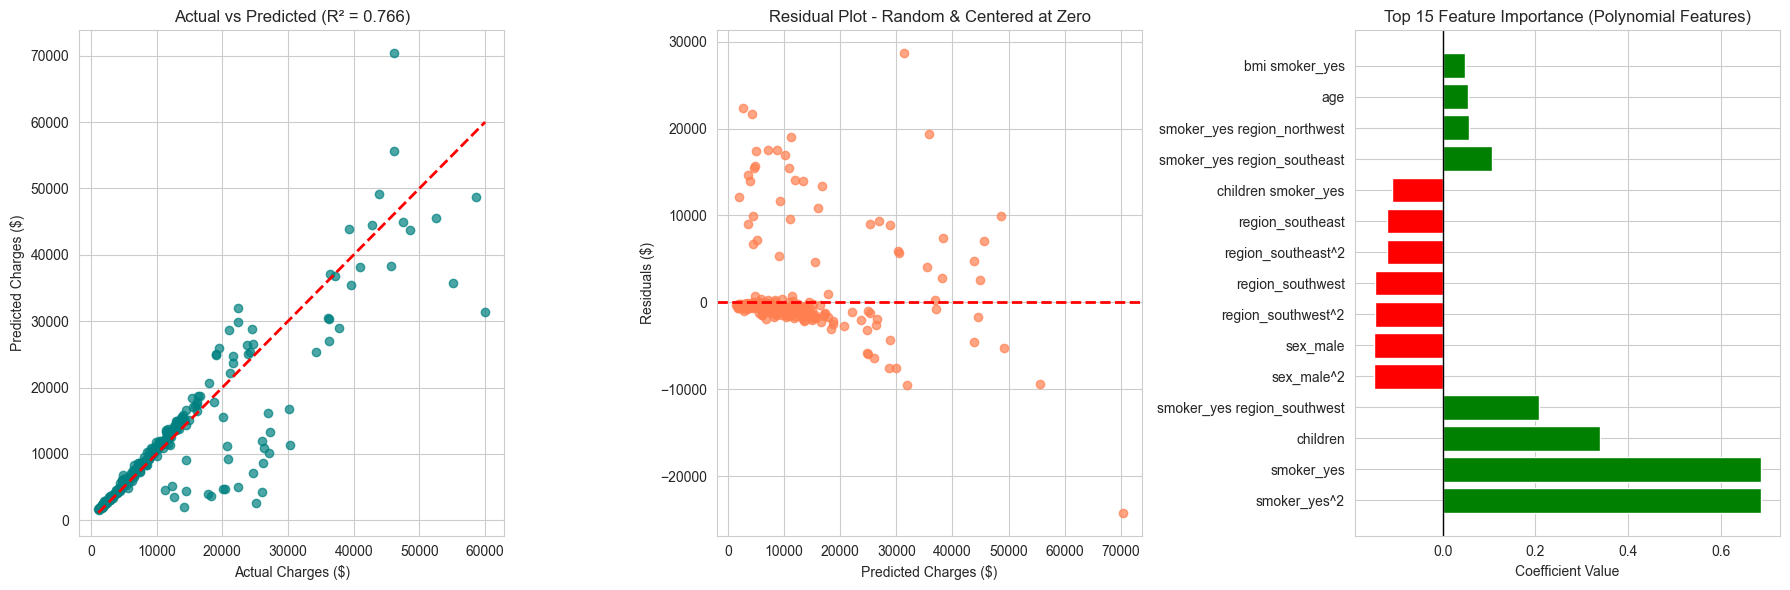

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Actual vs Predicted
axes[0].scatter(y_test_actual, y_test_pred, alpha=0.7, color='teal')
axes[0].plot([y_test_actual.min(), y_test_actual.max()], 
             [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Charges ($)')
axes[0].set_ylabel('Predicted Charges ($)')
axes[0].set_title(f'Actual vs Predicted (R² = {test_r2:.3f})')

# 2. Residual Plot
residuals = y_test_actual - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.7, color='coral')
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Charges ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('Residual Plot - Random & Centered at Zero')

# 3. Feature Importance (Coefficients)
feature_names = poly.get_feature_names_out(X.columns)
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_   
}).sort_values(by='Coefficient', key=abs, ascending=False).head(15)

colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
axes[2].barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
axes[2].set_xlabel('Coefficient Value')
axes[2].set_title('Top 15 Feature Importance (Polynomial Features)')
axes[2].axvline(0, color='black', linewidth=1)

plt.tight_layout()
plt.savefig('linear_regression_visualizations.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualizations generated and saved successfully!")
plt.show()

# 9.Final Summery

In [9]:
print("\n" + "="*70)
print("FINAL SUMMARY - LINEAR REGRESSION")
print("="*70)
print(f" Model completed")
print(f" R² Score       : {test_r2* 100:.2f}")
print(f" MAE            : ${test_mae:,.0f}")
print(f" ±20% Accuracy  : {within_20:.1f}%")
print(f" ±30% Accuracy  : {within_30:.1f}%")
print("="*70)


FINAL SUMMARY - LINEAR REGRESSION
 Model completed
 R² Score       : 76.62
 MAE            : $2,849
 ±20% Accuracy  : 71.1%
 ±30% Accuracy  : 79.8%
